# Analysis of a NOAA weather dataset ###

In this notebook we are analyzing a sample out of data that was downloaded from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/, the main file is ghcnd_all.tar.gz which is about 2.4 GB which becomes around 20GB when uncompressed.

The data contains about 1 million station-year recordings. That is too much to analyzer on single core machine, so we start by taking a sample of 20,000 recordings of the maximal daily temperatures for a period of a 365 days starting on January 1st (the last day of leap years is discarded).

## Checking the versions of some important packages ###

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print 'pandas version: ',pd.__version__
print 'numpy version:',np.__version__
print 'sklearn version:',sk.__version__
print 'matplotlib version:', matplotlib.__version__

pandas version:  0.20.3
numpy version: 1.13.3
sklearn version: 0.19.0
matplotlib version: 2.0.2


In [3]:
#if a version of a module is too old, you can use the following command to update it
#!pip install --upgrade matplotlib

## Data loading and analysis
Switch to the data directory and check it's contents

In [4]:
%cd ../data/weather
!ls -lh

/Users/prashantkolkur/Documents/DSE/pkolkur/DSE200/data/weather
total 159696
-rw-r--r--  1 prashantkolkur  staff   839K Oct 27 15:47 ALL.corrupted.csv
-rw-r--r--  1 prashantkolkur  staff   839K Oct 27 15:47 ALL.head.csv
-rw-r--r--  1 prashantkolkur  staff    25M Oct 27 15:47 SAMPLE_TMAX.csv
-rw-r--r--  1 prashantkolkur  staff    13K Oct 27 15:47 TMAX.10.csv
-rw-r--r--  1 prashantkolkur  staff     0B Oct 27 15:47 TMAX.head.csv
-rw-r--r--  1 prashantkolkur  staff   218B Oct 27 15:47 data-source.txt
-rw-r--r--  1 prashantkolkur  staff    22K Oct 27 15:47 ghcnd-readme.txt
-rw-r--r--  1 prashantkolkur  staff   7.0M Oct 27 15:47 ghcnd-stations.txt
-rw-r--r--  1 prashantkolkur  staff   7.4M Oct 27 15:47 ghcnd-stations_buffered.txt
-rw-r--r--  1 prashantkolkur  staff   270B Oct 27 15:47 ghcnd-version.txt
-rw-r--r--  1 prashantkolkur  staff    37M Oct 27 15:47 make_covar.raw_256


In [5]:
!cat data-source.txt

I got the data from this ftp site:

ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/

Opening the ftp site in a browser is helpful: you can easily browse the directory structure and look at txt and
pdf files.

Yoav Freund


### The main files
- *data-source.txt* - information about downloading the data from NOAA
- *ghcnd-readme.txt* - A readme file describing the content of all of the files from ghcnd, in particular:
- *ghcnd-stations.txt* - information about each of the meteorological stations.
- *Sample_TMAX* - a file with 10,000 randomly selected one-year-long TMAX measurements

In [6]:
# read a single line in the data file
file=open('SAMPLE_TMAX.csv','r')
for line in file.readlines():
    print line
    print len(line.split(','))
    break

USC00507570,TMAX,2005,67,44,61,17,-17,-22,-39,-44,-44,-78,-156,-156,-33,28,39,22,-89,-139,-156,44,61,50,-39,17,67,61,-61,-61,11,33,-72,-100,-150,-178,-150,-33,39,28,22,11,-150,-156,-150,50,44,28,39,50,56,39,67,50,39,56,50,56,44,22,6,17,17,61,83,67,67,89,78,61,61,83,56,44,67,89,67,89,100,83,56,17,22,50,39,28,-6,28,-6,-28,-50,-44,-33,-22,-22,-22,17,67,67,78,94,89,72,56,89,111,94,83,56,11,28,56,89,133,133,128,178,167,194,211,189,178,161,172,144,133,128,117,183,200,211,211,178,172,133,150,128,133,150,150,178,211,200,133,172,144,161,156,139,150,133,144,161,150,161,200,183,228,222,183,144,150,178,167,183,239,239,267,244,222,222,117,189,233,194,206,261,228,211,222,261,228,228,200,194,183,233,244,217,267,250,217,161,200,200,194,250,261,222,194,183,161,206,228,228,222,206,200,167,183,194,172,200,189,167,183,194,200,206,217,206,244,267,256,278,294,278,256,228,228,189,206,211,211,161,156,144,156,161,156,167,139,122,144,139,156,150,144,128,144,128,150,150,133,144,172,156,106,161,161,122,122,133,11

### read data into a Pandas Dataframe ##
* Read the data into a DataFrame
* Read the data vectors in G
* Divide by 10.0 to get the temperatude in degrees celsius
* Replace values outside the range [-400,500]  ([-40,50] degrees celsius) with nan  
* Paste fixed matrix back into Dout
* Show the first few lines of DDout

In [7]:
#create an index that is a range of dates
#using 2001 which was not a leap year (2000 was)
days_index=pd.date_range('January 1, 2001', periods=365,freq='D')
days=list(days_index)
days[:2]

[Timestamp('2001-01-01 00:00:00', freq='D'),
 Timestamp('2001-01-02 00:00:00', freq='D')]

In [8]:
columns=['station','measurement','year']+days
Data = pd.read_csv('SAMPLE_TMAX.csv',header=None,names=columns)
Data.head()

,station,measurement,year,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,2001-01-07 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,TMAX,2005,67.0,44.0,61.0,17.0,-17.0,-22.0,-39.0,...,-39.0,-33.0,-17.0,39.0,61.0,50.0,61.0,61.0,44.0,61.0
1,NOE00135018,TMAX,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,31.0,45.0,42.0,32.0,16.0,20.0,22.0,39.0,61.0
2,KZ000036546,TMAX,1982,NaN,NaN,-139.0,NaN,NaN,-45.0,NaN,...,NaN,-73.0,NaN,NaN,NaN,-170.0,-166.0,-160.0,-135.0,-99.0
3,USC00054664,TMAX,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.0,78.0,33.0,NaN,NaN,39.0,56.0,-39.0,-150.0,-150.0
4,CUW00011706,TMAX,1981,300.0,283.0,300.0,300.0,283.0,289.0,289.0,...,300.0,311.0,322.0,311.0,311.0,322.0,322.0,311.0,311.0,311.0


### Selecting rows and columns in a dataframe

* To select a set of columns from a dataframe:
```
DF[['column2','column6','column1']]
```
This returns a new dataframe containing the selected columns in the selected order.

* To select a set of rows based on a condition defined using one of the coluns:
```
DF[DF['column1']>5]
```

More sophisticated selections can be down using:
* `.loc` : select according to the **name** of the column or row.
* `.iloc` : select according to the **position** of the column or row.

Resources:
* [A tutorial on selecting rows and columns in a dataframe using iloc, loc and](https://pandas.pydata.org/pandas-docs/stable/indexing.html)
* [Pandas Cheat Sheet](https://github.com/pandas-dev/pandas/raw/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) (newer and better than the one in the folder).

In [13]:
# some data cleaning
G=Data.loc[:,days]
G[G<-400]=np.nan
G[G>500]=np.nan
G=G/10
Data.loc[:,days]=G
G=G.transpose()
Data

,station,measurement,year,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,2001-01-07 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,TMAX,2005,0.0067,0.0044,0.0061,0.0017,-0.0017,-0.0022,-0.0039,...,-0.0039,-0.0033,-0.0017,0.0039,0.0061,0.0050,0.0061,0.0061,0.0044,0.0061
1,NOE00135018,TMAX,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0058,0.0031,0.0045,0.0042,0.0032,0.0016,0.0020,0.0022,0.0039,0.0061
2,KZ000036546,TMAX,1982,NaN,NaN,-0.0139,NaN,NaN,-0.0045,NaN,...,NaN,-0.0073,NaN,NaN,NaN,-0.0170,-0.0166,-0.0160,-0.0135,-0.0099
3,USC00054664,TMAX,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0094,0.0078,0.0033,NaN,NaN,0.0039,0.0056,-0.0039,-0.0150,-0.0150
4,CUW00011706,TMAX,1981,0.0300,0.0283,0.0300,0.0300,0.0283,0.0289,0.0289,...,0.0300,0.0311,0.0322,0.0311,0.0311,0.0322,0.0322,0.0311,0.0311,0.0311
5,KG000036982,TMAX,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0150
6,SZ000002220,TMAX,1994,-0.0058,-0.0028,-0.0017,-0.0050,-0.0061,-0.0039,-0.0012,...,-0.0130,-0.0048,-0.0034,-0.0044,-0.0066,-0.0034,-0.0013,0.0029,-0.0028,-0.0075
7,RSM00028275,TMAX,1986,-0.0114,-0.0041,-0.0022,-0.0150,-0.0167,-0.0113,-0.0070,...,-0.0315,-0.0282,-0.0236,-0.0254,-0.0259,-0.0259,-0.0295,-0.0268,-0.0225,-0.0186
8,USC00488705,TMAX,1982,0.0011,-0.0033,-0.0044,-0.0006,-0.0022,-0.0139,-0.0089,...,0.0056,0.0061,0.0033,-0.0039,0.0006,-0.0028,-0.0083,-0.0072,-0.0067,-0.0022
9,USC00116558,TMAX,2013,0.0000,-0.0044,0.0011,-0.0006,0.0022,0.0022,0.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


shape(tmp)= (7300000,) type(tmp)= <class 'pandas.core.series.Series'>
min=-4.00,max=5.00


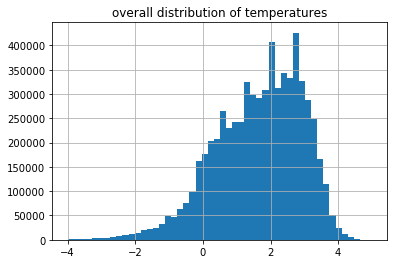

In [11]:
# compute the histogram
tmp=G.loc[:,:].unstack()
print 'shape(tmp)=',shape(tmp),'type(tmp)=',type(tmp)
tmp.hist(bins=50);
title('overall distribution of temperatures')
print 'min=%3.2f,max=%3.2f'%(tmp.min(),tmp.max())

## Plotting temperature as a function of day-of-year

### Script for plotting yearly plots ###

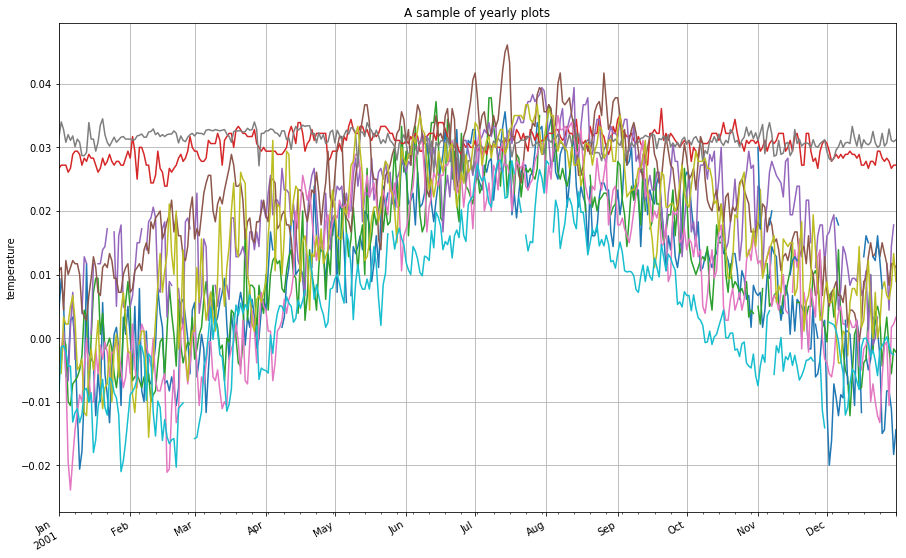

In [14]:
def YearlyPlots(T,ttl='',size=(15,10)):
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    T.set_index(days_index)
    T.plot(legend=False,figsize=size)
    # rotate and align the tick labels so they look better
    gcf().autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
YearlyPlots(Data.loc[20:30, days].transpose(),ttl='A sample of yearly plots')

### Plots for sydney, Australia ###

['ASN00066124' 'ASN00066059' 'ASN00066194' 'ASN00066131' 'ASN00066195'
 'ASN00066062']
(368, 6)


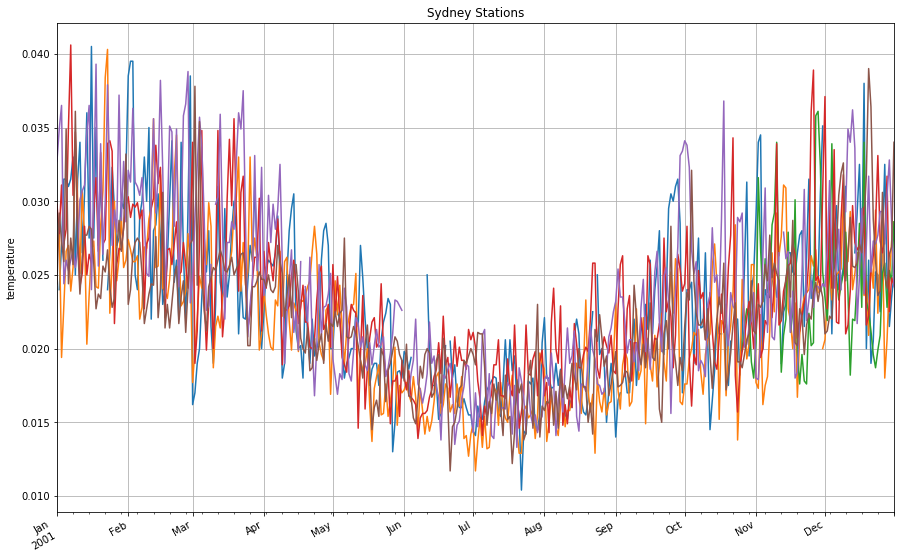

In [15]:
sydneyStations=['ASN00066' in station for station in Data['station']]
print Data[sydneyStations]['station'].values
tmp=Data[sydneyStations].transpose()
print shape(tmp)
YearlyPlots(tmp.loc[days,:],ttl='Sydney Stations')

## Computing statistics when there are missing values

### Computing mean and std for each station/year ###
And calculating the standard deviation for each year.

In [16]:
# a simple scale function to normalize the data-frame row-by-row
from numpy import mean, std
def Compute_mean_std(Din):
    matrix=Din.loc[:,days]
    Din['Mean']=mean(matrix, axis=1).values 
    Din['Std']=std(matrix, axis=1).values
    return Din

if 'measurement' in Data.columns:
    Data=Data.drop('measurement',axis=1)  # remove column that is the constant TMAX
Dout=Compute_mean_std(Data)
#reorder the columns
Dout=Dout[['station','year','Mean','Std']+days]
Dout.head()

,station,year,Mean,Std,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,2005,0.008532,0.010440,0.0067,0.0044,0.0061,0.0017,-0.0017,-0.0022,...,-0.0039,-0.0033,-0.0017,0.0039,0.0061,0.0050,0.0061,0.0061,0.0044,0.0061
1,NOE00135018,1959,0.014495,0.007974,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0058,0.0031,0.0045,0.0042,0.0032,0.0016,0.0020,0.0022,0.0039,0.0061
2,KZ000036546,1982,0.007221,0.014897,NaN,NaN,-0.0139,NaN,NaN,-0.0045,...,NaN,-0.0073,NaN,NaN,NaN,-0.0170,-0.0166,-0.0160,-0.0135,-0.0099
3,USC00054664,1964,0.018577,0.010790,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0094,0.0078,0.0033,NaN,NaN,0.0039,0.0056,-0.0039,-0.0150,-0.0150
4,CUW00011706,1981,0.031321,0.001589,0.0300,0.0283,0.0300,0.0300,0.0283,0.0289,...,0.0300,0.0311,0.0322,0.0311,0.0311,0.0322,0.0322,0.0311,0.0311,0.0311


### Compute average temperature for each day of the year. ###

(365, 1)

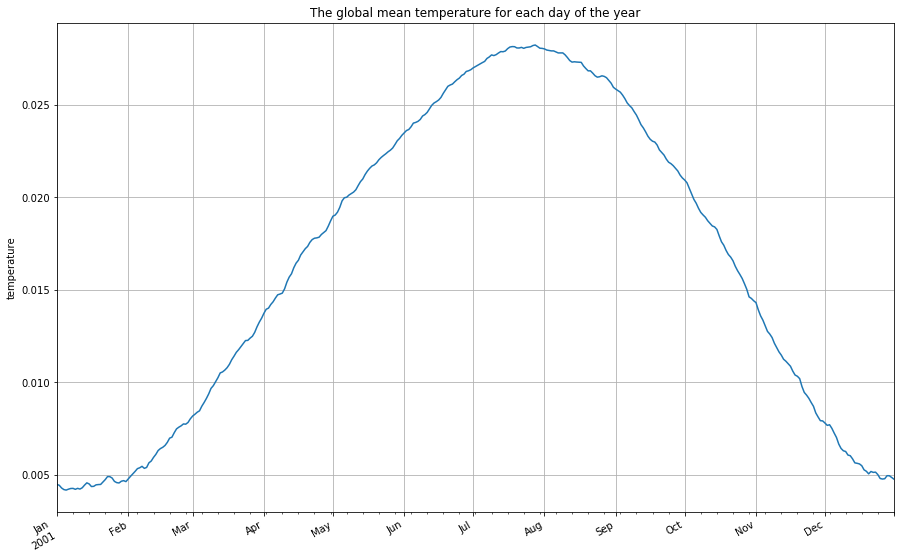

In [17]:
Mean=pd.DataFrame(mean(Dout.loc[:,days], axis=0)) 
YearlyPlots(Mean,ttl='The global mean temperature for each day of the year')
shape(Mean)

### Distribution of missing values
We find the distribution of missing values and decide how to deal with them. From the analysis below we see that most rows have some
missing values. We therefor choose to perform the average more carefully, rather than discard rows with many missing values

3760

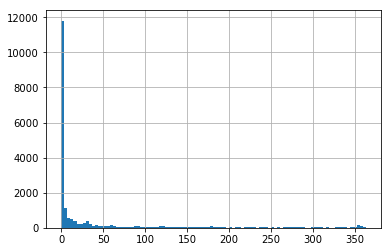

In [18]:
nan_per_row=sum(isnan(Dout.iloc[:,1:365]),axis=1) 
nan_per_row.hist(bins=100)
sum(nan_per_row>50)

### Computing the covariance matrix in a NaN-tolerant fashion
We compute the empirical covariance matrix in a way that tolerates small numbers of missing values.


In [19]:
sum(nan_per_row>50)

3760

In [20]:
max_nan=50

M=Dout.loc[:,days].transpose()
#M.drop(nan_per_row>0,axis=1,inplace=True)
M=M.loc[:,nan_per_row<max_nan]
Dout=Dout.loc[nan_per_row<max_nan,:]
Dout.index=range(shape(Dout)[0])
(columns,rows)=shape(M)
Mean=mean(M, axis=1).values

print (columns,rows), shape(Mean),shape(M),shape(Dout)
C=np.zeros([columns,columns])   # Sum
N=np.zeros([columns,columns])   # Counter of non-nan entries
Dout.head()

(365, 16217) (365,) (365, 16217) (16217, 369)


,station,year,Mean,Std,2001-01-01 00:00:00,2001-01-02 00:00:00,2001-01-03 00:00:00,2001-01-04 00:00:00,2001-01-05 00:00:00,2001-01-06 00:00:00,...,2001-12-22 00:00:00,2001-12-23 00:00:00,2001-12-24 00:00:00,2001-12-25 00:00:00,2001-12-26 00:00:00,2001-12-27 00:00:00,2001-12-28 00:00:00,2001-12-29 00:00:00,2001-12-30 00:00:00,2001-12-31 00:00:00
0,USC00507570,2005,0.008532,0.010440,0.0067,0.0044,0.0061,0.0017,-0.0017,-0.0022,...,-0.0039,-0.0033,-0.0017,0.0039,0.0061,0.0050,0.0061,0.0061,0.0044,0.0061
1,CUW00011706,1981,0.031321,0.001589,0.0300,0.0283,0.0300,0.0300,0.0283,0.0289,...,0.0300,0.0311,0.0322,0.0311,0.0311,0.0322,0.0322,0.0311,0.0311,0.0311
2,SZ000002220,1994,0.002395,0.006695,-0.0058,-0.0028,-0.0017,-0.0050,-0.0061,-0.0039,...,-0.0130,-0.0048,-0.0034,-0.0044,-0.0066,-0.0034,-0.0013,0.0029,-0.0028,-0.0075
3,RSM00028275,1986,0.003973,0.014084,-0.0114,-0.0041,-0.0022,-0.0150,-0.0167,-0.0113,...,-0.0315,-0.0282,-0.0236,-0.0254,-0.0259,-0.0259,-0.0295,-0.0268,-0.0225,-0.0186
4,USC00488705,1982,0.012108,0.011889,0.0011,-0.0033,-0.0044,-0.0006,-0.0022,-0.0139,...,0.0056,0.0061,0.0033,-0.0039,0.0006,-0.0028,-0.0083,-0.0072,-0.0067,-0.0022


In [21]:
#%%time
for i in range(rows):
    if i % 1000==0: 
        print i
    row=M.iloc[:,i]-Mean;
    outer=np.outer(row,row)
    valid=isnan(outer)==False
    C[valid]=C[valid]+outer[valid]  # update C with the valid location in outer
    N[valid]=N[valid]+1
#valid_outer=np.multiply(1-isnan(N),N>0)
cov=np.divide(C,N)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


## Singular Value Decomposition (PCA)

In [ ]:
shape(cov)

In [ ]:
U,D,V=np.linalg.svd(cov)

In [ ]:
shape(U),shape(D),shape(V)

### Percentage of variance Explained ###

In [ ]:
plot(cumsum(D[:])/sum(D))
xlim([0,365])
grid()

In [ ]:
k=5 # number of components to show.
DF_U=pd.DataFrame(U[:,:k])
print shape(DF_U)
YearlyPlots(DF_U,ttl='The most significant eigen-vectors')
legend(range(0,k));

In [ ]:
k=5
Eig=np.matrix(U[:,:k])
print 'checking that the norm of the eigenvectors is always 1'
print ['%6.3f,'%np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.loc[:,days])-Mean.transpose()

#replacing nans with zeros
matrix[isnan(matrix)]=0
print shape(Eig),shape(matrix)
Prod=matrix*Eig;
print shape(Prod)

Insert coefficients for k top eigenvectors into the dataframe **Dout**

In [ ]:
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

## Geographic location of stations
Loading the station longitude/latitude and merging it into the Table

In [ ]:
!cat ghcnd-readme.txt   # uncomment to read the readme file.

In [ ]:
# Make all lines be of length 90 to solve problem wilth read_fwf
out=open('ghcnd-stations_buffered.txt','w')
for line in open('ghcnd-stations.txt','r').readlines():
    line=line.rstrip()
    string=line+' '*(90-len(line))+'\n'
    out.write(string)
out.close()

In [ ]:
colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

In [ ]:
#stations['elevation'][stations['elevation']==-999.9]=0  # decided not to remove -999.9 because this confuses hist

In [ ]:
stations.head()

### perform a **JOIN** ###
Join the geographical information into **Dout**, creating a new dataframe called **Djoined**

In [ ]:
Djoined=Dout.join(stations,on='station')

In [ ]:
Djoined.columns

In [ ]:
Djoined['AbsLatitude']=abs(Djoined['latitude'].values)

In [ ]:
Djoined.loc[:5,['station',u'longitude','latitude',u'elevation',u'AbsLatitude','Mean','Std','V0','V1','V2']]

## Looking for significant correlations and dependencies
Each station is no described by a small number of features. We would like to understand the dependencies between these features.

In [ ]:
Reduced=Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']]
Reduced.cov()

<span style="color:red"> The correlations between different $V_i$ components should be zero, which it isn't.
Is this due to numerical roundoff errors? Are the correlations statistically significant for this sample size? </span>

In [ ]:
Reduced.corr()

In [ ]:
# Choosing significance threshold so that none of the correlations between the Vi-s are significant.
abs(Reduced.corr())>0.2

In [ ]:
X='latitude'
Djoined.loc[:,X].hist(bins=100);

In [ ]:
X='Mean';Y='V0'
figure(figsize=(10,10))
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)

In [ ]:
#checking for an anomaly in the elevations of stations
Djoined[['station','elevation']][Djoined['elevation']<-500].head()

In [ ]:
!grep ASN00010865 ghcnd-stations.txt

### Create a pickle file for the maps notebook

In [ ]:
import pickle
Dict={
    'Djoined':Djoined,
    'stations':stations
     }
pickle.dump(Dict,open('weather.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)

# Data Reconstruction

Using PCA, and based on the fact that the top eigenvectors explain most of the variance, we have represented each (year,station) temperature sequence (365 numbers) using just 5 numbers. We can use the associated eigen-vectors to construct and approximation of the original temperature sequence.

In [ ]:
#pd.DataFrame(np.ones(Kprod.shape[0],1)*KMean)


In [ ]:
KMean=np.array([Mean])
Recon0=pd.DataFrame(np.ones([Kprod.shape[0],1])*KMean)
Recon0.columns=days_index
Recon_k=[Recon0]
print Recon0.shape

for k in range(1,10):
    Keig=Eig[:,:k]
    Kprod=Prod[:,:k]
    Recon=pd.DataFrame(Kprod*Keig.transpose() +KMean)
    Recon.columns=days_index
    Recon_k.append(Recon)
    print k,Recon_k[k].shape

In [ ]:
print shape(Djoined.loc[i,days])
print shape(Recon.loc[i,days])

shape(Djoined),shape(Recon)

In [ ]:
def plot_reconstructions(selection,rows=2,columns=7,size=3):
    plt.figure(figsize=(columns*size,rows*size),dpi=300)
    j=1;
    for i in selection:
        subplot(rows,columns,j); 
        j += 1; 
        if j>=rows*columns: 
            break
        (Djoined.loc[i,days]).plot()
        for k in range(3):
            (Recon_k[k].loc[i,days]).plot()
        title(Djoined.loc[i,'station']+' / '+str(Djoined.loc[i,'year']))
plot_reconstructions(range(2000,2006),rows=10,columns=3,size=5)

Observe in the reconstructions below that the blue line fills in (extrapolation/interpolation) the places where the measurements are not available. It also reduces the fluctuations in the relative to the original line. Recall the we are using the k top eigenvectors which explain about 88% of the variance.

<span style="color:red"> Check how the approximations change/improve as you increase the number of coefficients</span>

In [ ]:
plot_reconstructions([2012],rows=2,columns=2,size=6)

In [ ]:
hist(Djoined.loc[:,'V0'],bins=100);
title('Histogram of V0');

In [ ]:
selection= [i for i in range(shape(Djoined)[0]) if Djoined.loc[i,'latitude']<-10]
plot_reconstructions(selection,rows=7,columns=3, size=5)
shape(selection)

<span style="color:red">Can you reduce the reconstruction error (using a fixed number of eigenvectors) by splitting the stations according to region (for example country, state, latitudal range). Note that having a regions with very few readings defeats the purpose.

In [ ]:
shape(np.array([Mean]).transpose())